C:\Users\dell\AppData\Local\Temp\ipykernel_15348\1822201466.py:152: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  plt.savefig("AssociationRulesGraph.png", dpi=300, bbox_inches='tight')
c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


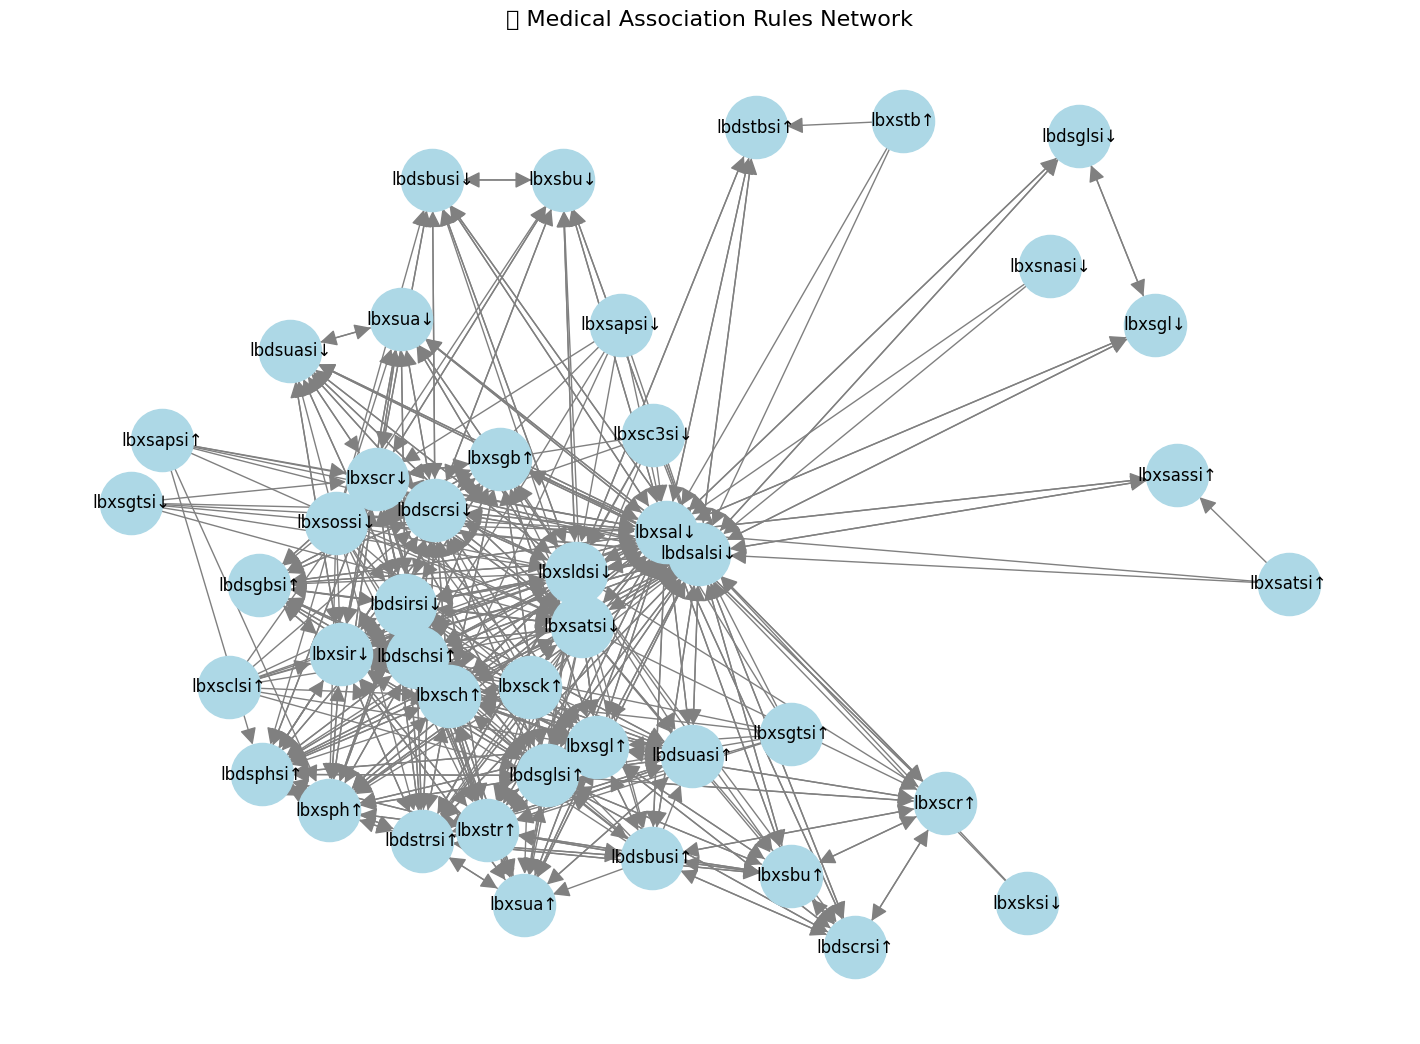


✅ Graph saved as 'AssociationRulesGraph.png' successfully!


In [ ]:
# --- 🌟 Step 1: Import libraries
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
import matplotlib.pyplot as plt
import networkx as nx

# Ignore RuntimeWarnings for clean output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- 🌟 Step 2: Load and Clean the Dataset
import os

base_dir = os.path.dirname(os.getcwd())
dataset_path = os.path.join(base_dir, "data", "Dataset.csv")
# Read manually to fix formatting issues
with open(dataset_path, "r", encoding="utf-8") as file:
    lines = file.readlines()
# with open("../Dataset.csv", "r", encoding="utf-8") as file:
#     lines = file.readlines()

# Split headers and data + clean them
header = lines[0].replace('"', '').strip().split(',')
data = [line.replace('"', '').strip().split(',') for line in lines[1:]] 
df = pd.DataFrame(data, columns=header) # cleaned data frame

# 5. dataset overview
# print(df.shape) # number of rows and columns
# print(df.columns) # list all columns names
# print(df.isnull().sum()) # sum of null values
# df.head() # display first 5 rows
# (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
# print(df.info()) # overview about the dataset
# print(df.dtypes) # Check data types of columns
# print(df.columns.tolist()) # check column names

# Convert from objects to numeric columns
numeric_columns = [
    "lbxsal", "lbdsalsi", "lbxsatsi", "lbxsassi", "lbxsapsi",
    "lbxsbu", "lbdsbusi", "lbxsca", "lbdscasi", "lbxsck", "lbxsch",
    "lbdschsi", "lbxsc3si", "lbxscr", "lbdscrsi", "lbxsgtsi", "lbxsgl",
    "lbdsglsi", "lbxsir", "lbdsirsi", "lbxsldsi", "lbxsph", "lbdsphsi",
    "lbxstb", "lbdstbsi", "lbxstp", "lbdstpsi", "lbxsua", "lbdsuasi",
    "lbxsnasi", "lbxsksi", "lbxsclsi", "lbxsossi", "lbxsgb", "lbdsgbsi",
    "lbxstr", "lbdstrsi"
]

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop 'seqn' (ID)
df = df.drop(columns=['seqn'])

# --- 🌟 Step 3: Normalize the values into -1, 0, 1
# standard normal ranges
normal_ranges = {
    'lbxsal': (135, 145), 'lbdsalsi': (135, 145), 'lbxsassi': (10, 40), 'lbxsapsi': (44, 147),
    'lbxsbu': (7, 20), 'lbdsbusi': (2.5, 7.1), 'lbxsca': (8.5, 10.2), 'lbdscasi': (2.12, 2.55),
    'lbxsck': (22, 198), 'lbxsch': (0, 200), 'lbdschsi': (0, 5.17), 'lbxsc3si': (22, 29),
    'lbxscr': (0.74, 1.35), 'lbdscrsi': (65.4, 119.3), 'lbxsgtsi': (9, 48), 'lbxsgl': (70, 99),
    'lbdsglsi': (3.9, 5.5), 'lbxsir': (60, 170), 'lbdsirsi': (10.7, 30.4), 'lbxsldsi': (140, 280),
    'lbxsph': (2.5, 4.5), 'lbdsphsi': (0.81, 1.45), 'lbxstb': (0.1, 1.2), 'lbdstbsi': (1.71, 20.5),
    'lbxstp': (6.0, 8.3), 'lbdstpsi': (60, 83), 'lbxsua': (3.5, 7.2), 'lbdsuasi': (208, 428),
    'lbxsnasi': (135, 145), 'lbxsksi': (3.5, 5.1), 'lbxsclsi': (98, 107), 'lbxsossi': (275, 295),
    'lbxsgb': (2.0, 3.5), 'lbdsgbsi': (20, 35), 'lbxstr': (0, 150), 'lbdstrsi': (0, 1.7),
    'lbxsatsi': (20, 55)
}
# function to normalize
def normalize(val, low, high):
    if val < low:
        return -1
    elif val > high:
        return 1
    else:
        return 0

normalized_df = pd.DataFrame()

for col, (low, high) in normal_ranges.items():
    normalized_df[col] = df[col].apply(lambda x: normalize(x, low, high))

# --- 🌟 Step 4: Create Transactions
# function to label values (up - down)
def get_label(col, val):
    if val == -1:
        return f"{col}↓"
    elif val == 1:
        return f"{col}↑"
    else:
        return None
# create transactions
transactions = []
for _, row in normalized_df.iterrows():
    items = [get_label(col, row[col]) for col in normalized_df.columns]
    transaction = list(filter(None, items))  # Remove None
    transactions.append(transaction)

# --- 🌟 Step 5: Apply Apriori Algorithm

# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Run Apriori
frequent_itemsets = apriori(df_encoded, min_support=0.02, use_colnames=True)

# Create rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# --- 🌟 Step 6: Clean & Present Rules

# Filter strong rules
strong_rules = rules[(rules['confidence'] >= 0.7) & (rules['lift'] >= 1)]

# Sort by confidence and lift
strong_rules = strong_rules.sort_values(by=['confidence', 'lift'], ascending=False)

# Beautify the output for thesis
# print("\n✅ Strong Association Rules for Medical Analysis:\n")
for idx, rule in strong_rules.iterrows():
    ant = ', '.join(list(rule['antecedents']))
    con = ', '.join(list(rule['consequents']))
    # print(f"If [{ant}] → Then [{con}] (Support: {rule['support']:.2f}, Confidence: {rule['confidence']:.2f}, Lift: {rule['lift']:.2f})")

# 🎨 Step 3: Visualize and save association graph
import networkx as nx
import matplotlib.pyplot as plt

if not strong_rules.empty:
    G = nx.DiGraph()

    for idx, rule in strong_rules.iterrows():
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['confidence'])

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw(G, pos, with_labels=True,
            node_color='lightblue', 
            node_size=2000, 
            edge_color='gray', 
            arrows=True, 
            arrowsize=25, 
            font_size=12)

    plt.title('🩺 Medical Association Rules Network', fontsize=16)
    
    # 📸 Save the graph automatically
    plt.savefig("AssociationRulesGraph.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Graph saved as 'AssociationRulesGraph.png' successfully!")
else:
    print("⚠️ No graph to display because no strong rules were found.")

# --- Convert rules to human-readable format + with metrics
formatted_rules = []

for _, row in strong_rules.iterrows():
    antecedent = ', '.join(list(row['antecedents']))
    consequent = ', '.join(list(row['consequents']))
    support = round(row['support'], 3)
    confidence = round(row['confidence'], 3)
    lift = round(row['lift'], 2)

    rule = (
        f"If a patient has [{antecedent}], they likely also have [{consequent}]. "
        f"(Support: {support}, Confidence: {confidence}, Lift: {lift})"
    )
    formatted_rules.append(rule)


# Save to TXT for LLM
with open("generated_rules.txt", "w", encoding="utf-8") as f:
    for rule in formatted_rules:
        f.write(rule + "\n")

